Notebook to define the basic subregions of miniJPAS to use for jackknife/bootstrap.

Will first **rotate** the coordinates to have them 'aligned' with the miniJPAS footprint.

After that, do the definition of the regions following the old `def_subregions_radec.py` script, and using an auxiliary random catalogue.

In this case, I will do 2 divisions in the 'rotated $\delta$' direction, and 8 divisions in the 'rotated $\alpha$' direction (i.e., regions will correspond roughly to quarters of each pointing).

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import astropy.coordinates as coord

In [3]:
plt.style.use('seaborn-talk')

/tmp/ipykernel_1655828/1058997633.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


## Define coordinates rotation

In [4]:
# In degrees
alpha_c = 214.52
delta_c = 52.65
theta_deg = -45.0

## Read in auxiliary catalogue

In [5]:
infile_aux = "rand_minijpas_1e5.radec"

In [6]:
dfrand = pd.read_csv(infile_aux, delim_whitespace=True)

In [7]:
dfrand.head()

,az(d),el(d),id
0,215.256615,52.802514,72
1,213.798679,52.348280,295
2,213.987403,52.464045,247
3,214.847363,52.766229,72
4,213.589702,52.086311,290


In [8]:
Ncat = len(dfrand)
print(Ncat)

100000


## Define function and rotate coordinates

(Following the `Rotation_Test` notebook)

In [9]:
def rotate_coordinates(alpha_c, delta_c, theta, data_df,
                      in_alpha_label='ALPHA', in_delta_label='DELTA',
                      out_alpha_label='ALPHA_rot', out_delta_label='DELTA_rot'):
    
    DEG2RAD = np.pi/180.
    RAD2DEG = 180./np.pi
    
    # Get Cartesian coordinates for the rotation axis
    rotaxis_cart = np.array(coord.spherical_to_cartesian(r=1, 
                                                         lat=delta_c*DEG2RAD,
                                                         lon=alpha_c*DEG2RAD
                                                        )
                           )
    
    # Get Cartesian coordinates for the data points
    points_cartesian = \
        np.array(coord.spherical_to_cartesian(r=1,
                                              lat=np.array(data_df[in_delta_label])*DEG2RAD,
                                              lon=np.array(data_df[in_alpha_label])*DEG2RAD)
                )
    
    # Do rotation of points using Rodrigues' formula
    theta_rad = theta*DEG2RAD
    term1 = points_cartesian*np.cos(theta_rad)
    term2 = np.cross(rotaxis_cart, points_cartesian.T).T*np.sin(theta_rad)
    term3 = np.outer(rotaxis_cart, np.dot(rotaxis_cart, points_cartesian))*(1. - np.cos(theta_rad))
    
    points_cart_new = term1 + term2 + term3
    
    # Convert back to 'new' spherical coordinates
    points_spher_new = \
        np.array(coord.cartesian_to_spherical(x=points_cart_new[0],
                                               y=points_cart_new[1],
                                               z=points_cart_new[2]))
    
    data_df[out_alpha_label] = points_spher_new[2]*RAD2DEG
    data_df[out_delta_label] = points_spher_new[1]*RAD2DEG

In [10]:
rotate_coordinates(alpha_c, delta_c, theta_deg, dfrand,
                  in_alpha_label='az(d)', in_delta_label='el(d)',
                  out_alpha_label='az_rot', out_delta_label='el_rot')

In [11]:
dfrand.head()

,az(d),el(d),id,az_rot,el_rot
0,215.256615,52.802514,72,215.216163,52.442515
1,213.798679,52.348280,295,213.655413,52.746634
2,213.987403,52.464045,247,213.925129,52.747317
3,214.847363,52.766229,72,214.886372,52.591878
4,213.589702,52.086311,290,213.200931,52.650900


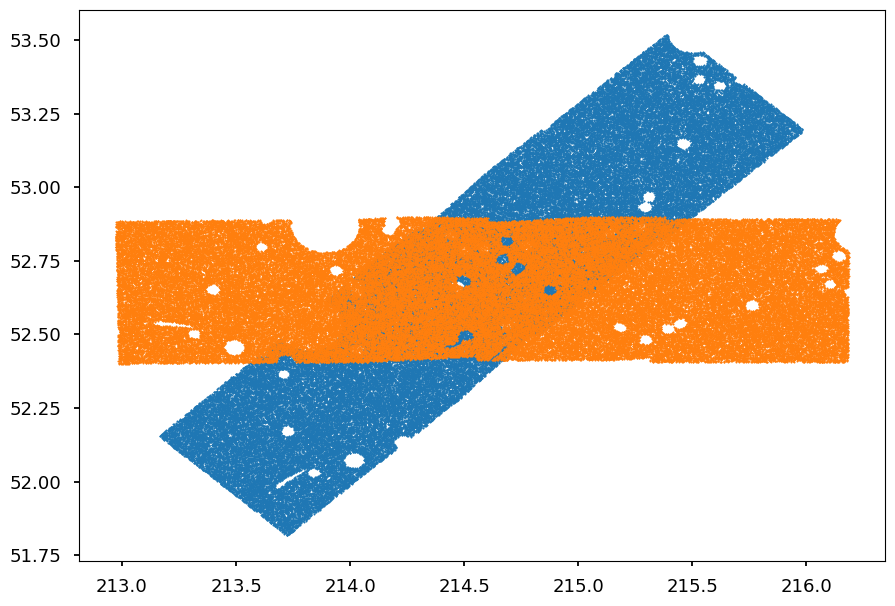

In [12]:
f, ax = plt.subplots()
ax.scatter('az(d)', 'el(d)', data=dfrand, s=1)
ax.scatter('az_rot', 'el_rot', data=dfrand, s=1)

## Define regions in rotated coordinates

In [13]:
RAROT_MIN_ABS = 212.
RAROT_MAX_ABS = 217.
DECROT_MIN_ABS = 52.
DECROT_MAX_ABS = 53.

##Define the number of regions we want to create,
##as number of division in each of the RA,DEC directions
NDEC = 1
NRA = 4
Nregions = NDEC*NRA
print(Nregions)

4


In [14]:
def define_limits_1d(dim_cat, Ndiv):
    """Defines the limits in one dimension that we need to create the sub-regions.
       Returns Ndiv-1 'internal' limits
    """

    assert Ndiv > 0

    perc_range = np.linspace(0, 100, Ndiv + 1)[1:-1]
    limits_1d = np.percentile(dim_cat, tuple(perc_range))

    return limits_1d

Check that coordinates and limits match

In [15]:
assert((dfrand['az_rot'] < RAROT_MAX_ABS).all())
assert((dfrand['az_rot'] > RAROT_MIN_ABS).all())
assert((dfrand['el_rot'] < DECROT_MAX_ABS).all())
assert((dfrand['el_rot'] > DECROT_MIN_ABS).all())

Define sub-region limits in DEC (strips)

In [16]:
lim_strips_dec = np.empty(NDEC+1, float)
lim_strips_dec[0] = DECROT_MIN_ABS
lim_strips_dec[1:-1] = define_limits_1d(dfrand['el_rot'], NDEC)
lim_strips_dec[-1] = DECROT_MAX_ABS

In [17]:
lim_strips_dec

array([52., 53.])

Define index lists for the different strips in DEC_ROT

In [18]:
#Use these limits to get index-lists for each dec strip
index_list_dec = np.empty((NDEC,Ncat), bool)

for i in range(NDEC):
    index_list_dec[i] = (dfrand['el_rot'] > lim_strips_dec[i])&(dfrand['el_rot'] <= lim_strips_dec[i+1])

In [19]:
index_list_dec

array([[ True,  True,  True, ...,  True,  True,  True]])

And define limits in RA for each DEC-strip

In [20]:
##Now, go over the strips defined in this way to obtain the RA limits in each case
lim_cols_ra = np.empty((NDEC, NRA+1), float)

for i in range(NDEC):
    lim_cols_ra[i,0] = RAROT_MIN_ABS
    lim_cols_ra[i,-1] = RAROT_MAX_ABS
    lim_cols_ra[i,1:-1] = define_limits_1d(dfrand['az_rot'][index_list_dec[i]], NRA)

In [21]:
lim_cols_ra

array([[212.        , 213.77496783, 214.61217764, 215.39650688,
        217.        ]])

Save to file (in same format as `def_subregions_radec.py`)

In [22]:
outfname = "subregs_minijpas_2x8.dat"

In [23]:
fout = open(outfname, 'w')

fout.write("#Sub-regions limits, as defined by notebok Def_SubRegs_miniJPAS_2x8.\n")
fout.write("#Limits defined in DEC_rot,RA_rot by a %dx%d 'quilt'\n" % (NDEC,NRA))
fout.write("#Parameters of the rotation of coordinates:\n")
fout.write(f"# alpha_c = {alpha_c}, delta_c = {delta_c}, theta_deg = {theta_deg}. \n")
fout.write("#Completeness based on random catalogue %s\n" % infile_aux)
fout.write("#\n")
fout.write("#Format: each line corresponds to one region, with columns:\n")
fout.write("# 1 DEC_min\n")
fout.write("# 2 DEC_max\n")
fout.write("# 3 RA_min\n")
fout.write("# 4 RA_max\n")
    
for i in range(NDEC):
    for j in range(NRA):
        fout.write("%g  %g  %g  %g\n" % (lim_strips_dec[i], lim_strips_dec[i+1], lim_cols_ra[i,j], lim_cols_ra[i,j+1]))
fout.close()


## Check regions

We assign points to regions, to check that everything works fine.

For this, adapt code from old `assing_reg2cat.py` script

In [24]:
def assign_reg(ra_in,dec_in, dec_min_reg, dec_max_reg, ra_min_reg, ra_max_reg):

    Ncat = len(ra_in)
    if len(dec_in) != Ncat:
        raise ValueError

    Nreg = len(dec_min_reg)

    if (len(dec_max_reg) != Nreg) or (len(ra_min_reg) != Nreg) or (len(ra_max_reg) != Nreg):
        raise ValueError

    ind_reg = np.empty((Nreg, Ncat), bool)

    for i in range(Nreg):
        ind_reg[i] = (dec_in > dec_min_reg[i])&(dec_in <= dec_max_reg[i])&(ra_in > ra_min_reg[i])&(ra_in <= ra_max_reg[i])

    if ind_reg.sum() < Ncat:
        raise Exception("Looks like there are points in the catalogue outside of the regions defined!!")

    elif ind_reg.sum() < Ncat:
        raise Exception("Looks like there is some overlap between regions!!")

    ##Create the region ID array (each value shows what is the region that points is assigned to)
    #reg_id = map(lambda x: np.arange(Nreg)[ind_reg[:,x]], range(Ncat))
    reg_id = [np.arange(Nreg)[ind_reg[:,x]] for x in range(Ncat)]
#    return reg_id
    reg_id = np.array(list(reg_id))[:,0]
    if len(reg_id) != Ncat:
        raise Exception("Something went wrong when creating the region ID array, len(reg_id) = %d!" % len(reg_id))


    return reg_id


In [25]:
dec_min, dec_max, ra_min, ra_max = np.loadtxt(outfname, usecols=range(4), unpack=True)
Nreg = len(dec_min)

In [26]:
Nreg

4

In [27]:
dec_min

array([52., 52., 52., 52.])

In [28]:
dfrand['reg_id'] = assign_reg(ra_in=dfrand['az_rot'], dec_in=dfrand['el_rot'],
                             dec_min_reg=dec_min, dec_max_reg=dec_max,
                             ra_min_reg=ra_min, ra_max_reg=ra_max)

In [29]:
dfrand

,az(d),el(d),id,az_rot,el_rot,reg_id
0,215.256615,52.802514,72,215.216163,52.442515,2
1,213.798679,52.348280,295,213.655413,52.746634,0
2,213.987403,52.464045,247,213.925129,52.747317,1
3,214.847363,52.766229,72,214.886372,52.591878,2
4,213.589702,52.086311,290,213.200931,52.650900,0
...,...,...,...,...,...,...
99995,214.633440,52.714422,100,214.675234,52.646897,2
99996,215.720768,53.111524,144,215.899173,52.462923,3
99997,214.773831,52.739142,100,214.803037,52.604218,2
99998,213.499052,51.956107,233,212.984837,52.597446,0


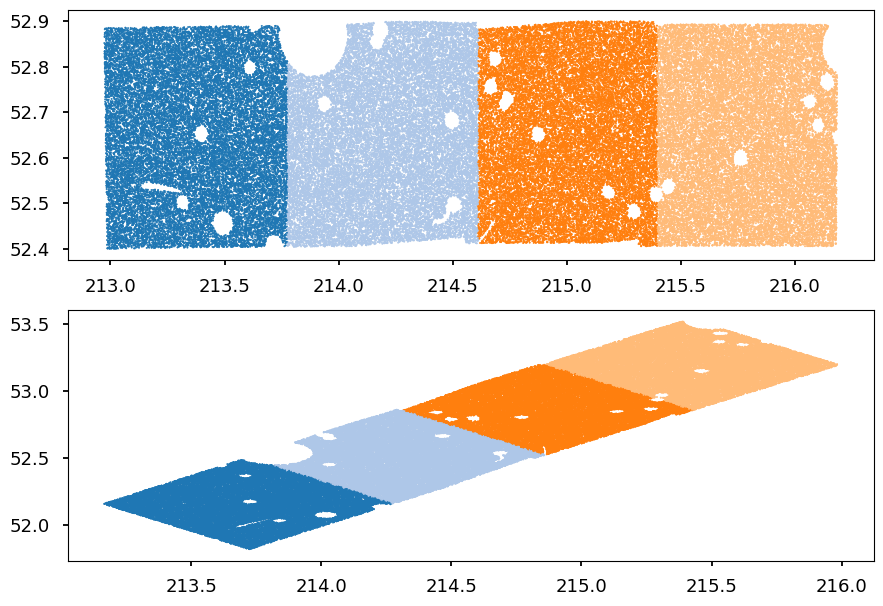

In [30]:
f, axes = plt.subplots(2, 1)
p1 = axes[0].scatter('az_rot', 'el_rot', data=dfrand, s=1, c='reg_id',
                     cmap='tab20', vmin=0, vmax=19)
axes[1].scatter('az(d)', 'el(d)', data=dfrand, s=1, c='reg_id',
                cmap='tab20', vmin=0, vmax=19)
#plt.colorbar(p1)

In [31]:
# Assign regions to selected LAEs in miniJPAS
path_to_selection = '/home/alberto/cosmos/LAEs/csv/selection.csv'
selection = pd.read_csv(path_to_selection)
mask_jnep = selection['tile_id'] != 2520

# Rotate selection coordinates
rotate_coordinates(alpha_c, delta_c, theta_deg, selection,
                  in_alpha_label='RA', in_delta_label='DEC',
                  out_alpha_label='RA_rot', out_delta_label='DEC_rot')

mj_region_id = assign_reg(ra_in=selection['RA_rot'][mask_jnep], dec_in=selection['DEC_rot'][mask_jnep],
                             dec_min_reg=dec_min, dec_max_reg=dec_max,
                             ra_min_reg=ra_min, ra_max_reg=ra_max)

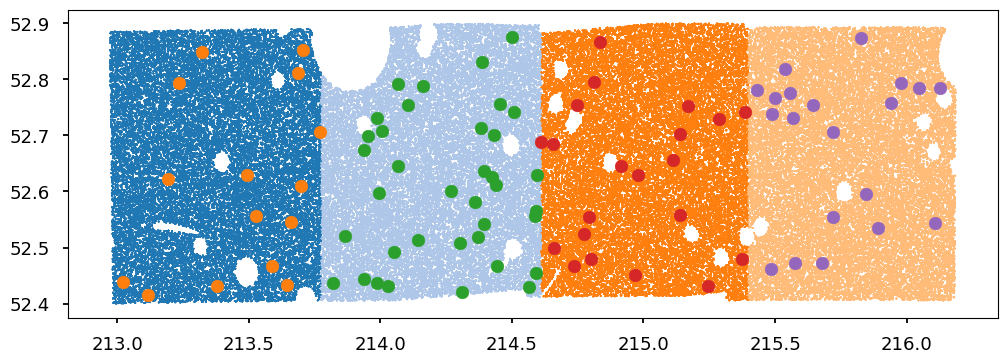

In [32]:
fig, ax = plt.subplots(figsize=(12, 4))

for i in range(4):
    ax.scatter('az_rot', 'el_rot', data=dfrand, s=1, c='reg_id',
                     cmap='tab20', vmin=0, vmax=19, zorder=-99)
    ax.scatter(selection['RA_rot'][mask_jnep][mj_region_id == i],
               selection['DEC_rot'][mask_jnep][mj_region_id == i],
              c=f'C{i+1}')
    
plt.show()

In [33]:
boots_region_id = np.ones(len(selection)).astype(int) * 4
boots_region_id[mask_jnep] = pd.Series(mj_region_id)
selection['boots_region_id'] = boots_region_id
selection

,Unnamed: 0,src,tile_id,x_im,y_im,nb_sel,SDSS_spCl,SDSS_zspec,RA,DEC,...,r,other_lines,color_mask,pm_mask,snr_mask,ml_mask,nice_nice,RA_rot,DEC_rot,boots_region_id
0,0,402,2406,7083.28760,648.055786,3,QSO,2.30541,215.324992,52.896109,...,20.573435,"[3, 14, 26]",True,True,True,True,True,215.372706,52.479496,2
1,1,533,2406,2928.11426,776.680115,5,NaN,NaN,215.025112,53.085950,...,22.039532,[4],True,True,True,True,True,215.384781,52.741353,2
2,2,1086,2406,2296.27686,1211.679080,1,NaN,NaN,215.009874,53.133437,...,21.278354,[],True,True,True,True,True,215.429937,52.781253,3
3,3,1390,2241,3470.82300,231.305771,1,QSO,1.00250,213.925689,52.368600,...,20.776354,[1],True,True,True,True,True,213.769844,52.706299,0
4,4,2317,2406,7369.45752,1733.409790,2,NaN,NaN,215.426167,52.931958,...,21.643579,[],True,True,True,True,True,215.485117,52.461656,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1,14480,2241,2196.81250,3994.304440,19,NaN,NaN,214.105378,52.593972,...,22.823470,"[19, 34]",True,True,True,True,True,214.160846,52.788448,1
123,2,23146,2406,6202.66113,5636.825200,18,NaN,NaN,215.628706,53.158187,...,22.543607,[],True,True,True,True,True,215.889574,52.534991,3
124,3,23401,2241,2717.86816,6822.033690,20,NaN,NaN,214.350697,52.697451,...,22.321430,[20],True,True,True,True,True,214.455705,52.756171,1
125,9,53205,2520,1280.43396,3833.844730,18,NaN,NaN,261.073655,65.749872,...,22.692801,[],True,True,True,True,True,254.607818,46.505986,4


In [34]:
# Save the ids
# np.save('/home/alberto/cosmos/LAEs/npy/selection_boots_region_ids', boots_region_id)